# Some Loss Plots

We will test Model6 and Ben9, as they were two of the better-performing models, and because they use two different architectures.

In [34]:
import json

import seaborn as sns
from pandas import Series, DataFrame, melt
from biom import Table
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from keras.models import model_from_json
from qiime2 import Artifact
from q2_types.feature_data import DNAIterator

from q2_feature_classifier._keras import (
    DNAEncoder, Seq2VecEncoder, _unpack_class_weights,
    TaxonomicGenerator, )

In [23]:
%matplotlib inline

## Model6
Load the data and set the parameters

In [2]:
reference_reads = Artifact.load('/home/ben/Data/treepop/ref/ref-seqs-v4-150.qza')
reference_reads = reference_reads.view(DNAIterator)
reference_taxonomy = Artifact.load('/home/ben/Data/treepop/ref/ref-tax.qza')
reference_taxonomy = reference_taxonomy.view(Series)
classifier_specification = Artifact.load('/home/ben/Data/treepop/animal-distal-gut/specs/Model6.qza')
classifier_specification = classifier_specification.view(dict)
class_weight = Artifact.load('/home/ben/Data/treepop/animal-distal-gut/weights.qza')
class_weight = class_weight.view(Table)
sequence_encoder = 'Seq2VecEncoder'
read_length = 144
k = 7
vec_length = 300
window = 5
n_jobs = 12
loss = 'categorical_crossentropy'
optimizer = 'adam'
batch_size = 2048
epochs = 20

### Create the encoders

In [3]:
# copy-and-pasted from _keras.fit_classifier_keras
X, y = zip(*[(str(s), [reference_taxonomy[s.metadata['id']]])
             for s in reference_reads
             if s.metadata['id'] in reference_taxonomy])

if sequence_encoder == 'DNAEncoder':
    x_encoder = DNAEncoder(read_length)
elif sequence_encoder == 'Seq2VecEncoder':
    x_encoder = Seq2VecEncoder(k, vec_length, window, read_length, n_jobs)
elif sequence_encoder == 'KmerEncoder':
    x_encoder = KmerEncoder(k, vec_length, read_length)

y_encoder = OneHotEncoder(sparse=False, handle_unknown='ignore')

x_encoder.fit(X)
y_encoder.fit(y)

OneHotEncoder(handle_unknown='ignore', sparse=False)

### Fit the model

In [4]:
# also copy-and-pasted from _keras.fit_classifier_keras but modified
# to track fitting progress
# generators not handled well for keras validation
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)
generator = TaxonomicGenerator(X_train, y_train, x_encoder, y_encoder, batch_size)
x_val = x_encoder.transform(X_test)
y_val = y_encoder.transform(y_test)
class_weight = _unpack_class_weights(class_weight, y_encoder)
val_sample_weights = y_val.dot(class_weight)
validation_data = (x_val, y_val, val_sample_weights)

In [5]:
# EEE So now we need to assert somewhere that keras_version is >= 2.3.0
model = model_from_json(json.dumps(classifier_specification))
classifier_specification = json.loads(model.to_json())  # to standardise
classifier_specification['config']['layers'][-1]['config']['units'] = \
    validation_data[1].shape[1]
model = model_from_json(json.dumps(classifier_specification))
model.compile(loss=loss, optimizer=optimizer, metrics=['accuracy'])
class_weight = {i: class_weight[i] for i in range(len(class_weight))}
history = model.fit(generator, epochs=epochs, class_weight=class_weight,
                    batch_size=batch_size, validation_data=validation_data)

Epoch 1/20
80/80 [==============================] - 108s 1s/step - loss: 0.0098 - accuracy: 0.1342 - val_loss: 0.0039 - val_accuracy: 0.2266
Epoch 2/20
80/80 [==============================] - 114s 1s/step - loss: 0.0034 - accuracy: 0.2741 - val_loss: 0.0031 - val_accuracy: 0.3089
Epoch 3/20
80/80 [==============================] - 116s 1s/step - loss: 0.0029 - accuracy: 0.3431 - val_loss: 0.0029 - val_accuracy: 0.3721
Epoch 4/20
80/80 [==============================] - 118s 1s/step - loss: 0.0026 - accuracy: 0.3913 - val_loss: 0.0027 - val_accuracy: 0.4092
Epoch 5/20
80/80 [==============================] - 125s 2s/step - loss: 0.0025 - accuracy: 0.4203 - val_loss: 0.0026 - val_accuracy: 0.4312
Epoch 6/20
80/80 [==============================] - 129s 2s/step - loss: 0.0024 - accuracy: 0.4449 - val_loss: 0.0027 - val_accuracy: 0.4446
Epoch 7/20
80/80 [==============================] - 130s 2s/step - loss: 0.0022 - accuracy: 0.4668 - val_loss: 0.0026 - val_accuracy: 0.4702
Epoch 8/20
80

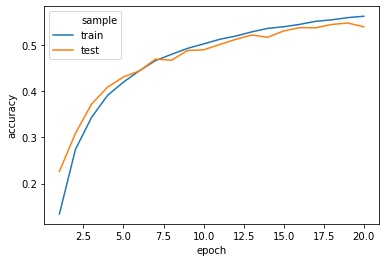

In [38]:
data = DataFrame({
    'train': history.history['accuracy'],
    'test': history.history['val_accuracy'],
    'epoch': range(1, len(history.history['accuracy']) + 1)
})
data = data.melt(id_vars='epoch', var_name='sample', value_name='accuracy')
sns.lineplot(data=data, x='epoch', y='accuracy', hue='sample')

### Save the history to save fitting the model again

In [40]:
with open('model6-history.json', 'w') as history_file:
    json.dump(history.history, history_file)

## Ben9
Load the data and set the parameters

In [52]:
reference_reads = Artifact.load('/home/ben/Data/treepop/ref/ref-seqs-v4-150.qza')
reference_reads = reference_reads.view(DNAIterator)
reference_taxonomy = Artifact.load('/home/ben/Data/treepop/ref/ref-tax.qza')
reference_taxonomy = reference_taxonomy.view(Series)
classifier_specification = Artifact.load('/home/ben/Data/treepop/animal-distal-gut/specs/Ben9.qza')
classifier_specification = classifier_specification.view(dict)
class_weight = Artifact.load('/home/ben/Data/treepop/animal-distal-gut/weights.qza')
class_weight = class_weight.view(Table)
sequence_encoder = 'DNAEncoder'
read_length = 150
k = 7
vec_length = 300
window = 5
n_jobs = 1
loss = 'categorical_crossentropy'
optimizer = 'adam'
batch_size = 64
epochs = 20

### Create the encoders

In [53]:
# copy-and-pasted from _keras.fit_classifier_keras
X, y = zip(*[(str(s), [reference_taxonomy[s.metadata['id']]])
             for s in reference_reads
             if s.metadata['id'] in reference_taxonomy])

if sequence_encoder == 'DNAEncoder':
    x_encoder = DNAEncoder(read_length)
elif sequence_encoder == 'Seq2VecEncoder':
    x_encoder = Seq2VecEncoder(k, vec_length, window, read_length, n_jobs)
elif sequence_encoder == 'KmerEncoder':
    x_encoder = KmerEncoder(k, vec_length, read_length)

y_encoder = OneHotEncoder(sparse=False, handle_unknown='ignore')

x_encoder.fit(X)
y_encoder.fit(y)

OneHotEncoder(handle_unknown='ignore', sparse=False)

### Fit the model

In [54]:
# also copy-and-pasted from _keras.fit_classifier_keras but modified
# to track fitting progress
# generators not handled well for keras validation
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)
generator = TaxonomicGenerator(X_train, y_train, x_encoder, y_encoder, batch_size)
x_val = x_encoder.transform(X_test)
y_val = y_encoder.transform(y_test)
class_weight = _unpack_class_weights(class_weight, y_encoder)
val_sample_weights = y_val.dot(class_weight)
validation_data = (x_val, y_val, val_sample_weights)

In [55]:
# EEE So now we need to assert somewhere that keras_version is >= 2.3.0
model = model_from_json(json.dumps(classifier_specification))
classifier_specification = json.loads(model.to_json())  # to standardise
classifier_specification['config']['layers'][-1]['config']['units'] = \
    validation_data[1].shape[1]
model = model_from_json(json.dumps(classifier_specification))
model.compile(loss=loss, optimizer=optimizer, metrics=['accuracy'])
class_weight = {i: class_weight[i] for i in range(len(class_weight))}
history = model.fit(generator, epochs=epochs, class_weight=class_weight,
                    batch_size=batch_size, validation_data=validation_data)

Epoch 1/20
2537/2537 [==============================] - 685s 270ms/step - loss: 0.0099 - accuracy: 0.1162 - val_loss: 0.0049 - val_accuracy: 0.2053
Epoch 2/20
2537/2537 [==============================] - 1368s 539ms/step - loss: 0.0042 - accuracy: 0.2594 - val_loss: 0.0038 - val_accuracy: 0.2933
Epoch 3/20
2537/2537 [==============================] - 1169s 461ms/step - loss: 0.0035 - accuracy: 0.3255 - val_loss: 0.0032 - val_accuracy: 0.3555
Epoch 4/20
2537/2537 [==============================] - 1086s 428ms/step - loss: 0.0031 - accuracy: 0.3594 - val_loss: 0.0032 - val_accuracy: 0.3876
Epoch 5/20
2537/2537 [==============================] - 1207s 476ms/step - loss: 0.0028 - accuracy: 0.3927 - val_loss: 0.0031 - val_accuracy: 0.3966
Epoch 6/20
2537/2537 [==============================] - 1275s 503ms/step - loss: 0.0028 - accuracy: 0.4102 - val_loss: 0.0033 - val_accuracy: 0.3956
Epoch 7/20
2537/2537 [==============================] - 1242s 489ms/step - loss: 0.0024 - accuracy: 0.4359 

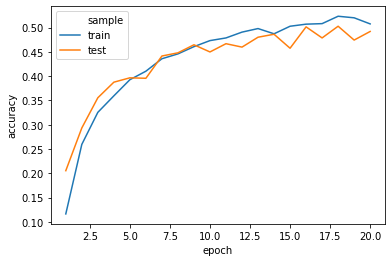

In [56]:
data = DataFrame({
    'train': history.history['accuracy'],
    'test': history.history['val_accuracy'],
    'epoch': range(1, len(history.history['accuracy']) + 1)
})
data = data.melt(id_vars='epoch', var_name='sample', value_name='accuracy')
sns.lineplot(data=data, x='epoch', y='accuracy', hue='sample')

### Save the history to save fitting the model again

In [57]:
with open('ben9-history.json', 'w') as history_file:
    json.dump(history.history, history_file)